---
title: "Download Skeletons"
aliases: 
    - em_py_04_skeleton_pathlength.html
draft: false
format: 
    html:
        toc: true 
        code-fold: false
        code-links:
          - text: Download Quickstart Notebooks
            icon: file-code
            href: https://github.com/AllenInstitute/microns_tutorial/tree/main/tutorial_book/quickstart_notebooks
execute:
    eval: False
    warning: False
jupyter: python3
---

# Connected morphological representations: skeletons

Often in thinking about neurons, you want to measure things along a linear dimension of a neuron.

However, the segmentation and meshes are a full complex 3d shape that makes this non-trivial. There are methods for reducing the shape of a segmented neuron down to a linear tree like structure usually referred to as a __skeleton__. We have precalculated skeletons for a large number of cells in the dataset, and make the skeleton generation available on our server, on demand. 

The meshes that one sees in Neuroglancer are available to download through the python client [cloud-volume](https://github.com/seung-lab/cloud-volume), and can be loaded for analysis and visualization in other tools.

{{< include _morphological_representations.qmd >}}



## What is a Precomputed skeleton?

These skeletons are stored in the cloud as a bytes-IO object, which can be viewed in __Neuroglancer__, or downloaded with __CAVEclient.skeleton__ module. These precomputed skeletons also contain annotations on the skeletons that have the synapses, which skeleton nodes are axon and which are dendrite, and which are likely the apical dendrite of excitatory neurons.


![pyChunkedGraph Skeleton](../img/skeleton-cartoon.png)

For more on how skeletons are generated from the mesh objects, and additional tools for generating, cacheing, and downloading meshes, [see the Skeleton Service documentation](https://caveconnectome.github.io/CAVEclient/tutorials/skeletonization/)

## CAVEclient to download skeletons
Retrieve a skeleton using `get_skeleton()`. The available output_formats (described below) are:

* `dict` containing vertices, edges, radius, compartment, and various metadata (default if unspecified)
* `swc` a Pandas Dataframe in the SWC format, with ordered vertices, edges, compartment labels, and radius.

Note: if the skeleton doesn't exist in the server cache, it may take 20-60 seconds to generate the skeleton before it is returned. This function will block during that time. Any subsequent retrieval of the same skeleton should go very quickly however.

::: {.callout-important}
## Initial Setup
Before using any programmatic access to the data, [you first need to set up your CAVEclient token](em_py_01_caveclient_setup.html).
:::

In [1]:
from caveclient import CAVEclient
import numpy as np
import pandas as pd

client = CAVEclient("minnie65_public")

# specify the materialization version, for consistency across time",
client.version = 1300

# Example: pyramidal cell in v1300
example_cell_id = 864691135572530981

In [2]:
sk_df = client.skeleton.get_skeleton(example_cell_id, output_format='swc')

sk_df.head()

,id,type,x,y,z,radius,parent
0,0,1,1365.120,763.456,812.60,3.643,-1
1,1,3,1368.200,755.760,811.24,0.300,0
2,2,3,1368.200,758.552,811.68,1.915,1
3,3,3,1368.200,758.560,812.12,1.915,2
4,4,3,1368.192,758.560,812.44,2.815,3


Skeletons are "tree-like", where every vertex (except the root vertex) has a single parent that is closer to the root than it, and any number of child vertices. Because of this, for a skeleton there are well-defined directions "away from root" and "towards root" and few types of vertices have special names:

You can see these vertices and edges represented in the alternative `dict` skeleton output.

In [3]:
sk_dict = client.skeleton.get_skeleton(example_cell_id, output_format='dict')

sk_dict.keys()

dict_keys(['meta', 'edges', 'mesh_to_skel_map', 'root', 'vertices', 'compartment', 'radius'])

Alternately, you can query a set of root_ids, for example all of the **proofread cells** in the dataset, and bulk download the skeletons

In [4]:
prf_root_ids = client.materialize.tables.proofreading_status_and_strategy(
    status_axon='t').query()['pt_root_id']
prf_root_ids.head(3)

0    864691135441799752
1    864691135855890478
2    864691136521831825
Name: pt_root_id, dtype: int64

In [6]:
all_sk_dict = client.skeleton.get_bulk_skeletons(
    prf_root_ids.head(3), 
    generate_missing_skeletons=False,
    output_format='dict',
    skeleton_version=4)

all_sk_dict.keys()

dict_keys(['864691135441799752', '864691135855890478', '864691136521831825'])

## Download or generate skeletons with `pcg_skel`

`pcg_skel` is a package used to rapidly build neuronal skeletons from electron microscopy data in the CAVE ecosystem. It integrates structural data, connectivity data, and local features stored across many aspects of a CAVE system, and creates objects as [Meshparty](https://github.com/CAVEconnectome/MeshParty) meshes, skeletons, and MeshWork files for subsequent analysis. 

By harnessing the way the structural data is stored, you can build skeletons for even very large neurons quickly and with little memory use.

To install pcg_skel, use pip. 

```python
pip install pcg_skel
```

By loading a skeleton with MeshParty, you can easily 'rehydrate' the mesh features of the neuron (such as synapses) and MeshParty functions (such as masking)

In [10]:
from pcg_skel import get_meshwork_from_client

sk_mesh = get_meshwork_from_client(example_cell_id,
                                   client=client,
                                   synapses=True,
                                   # restore_graph=True,
                                   restore_properties=True,
                                   skeleton_version=4,
)
sk_mesh

## Plot with `skeleton_plot`

Our convenience package __skeleton_plot__ renders the skeleton in aligned, 2D views.

```python
pip install skeleton_plot
```

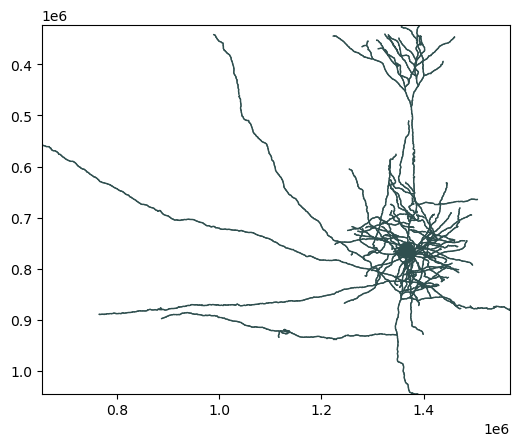

In [11]:
import skeleton_plot

skeleton_plot.plot_tools.plot_skel(sk=sk_mesh.skeleton,
                                   invert_y=True,
                                   pull_compartment_colors=False,
                                   plot_soma=True)